In [1]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 16.50 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [2]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl
!pip install RegscorePy

/tmp/ipykernel_18350/707780074.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


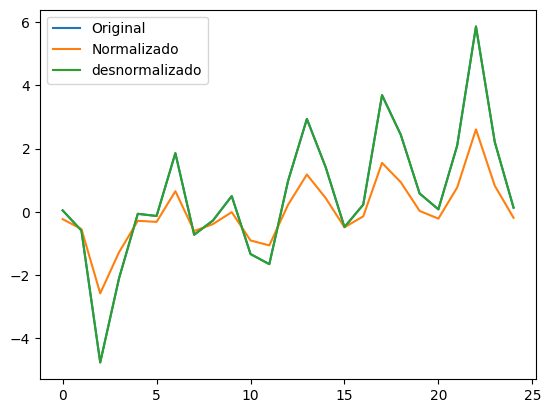

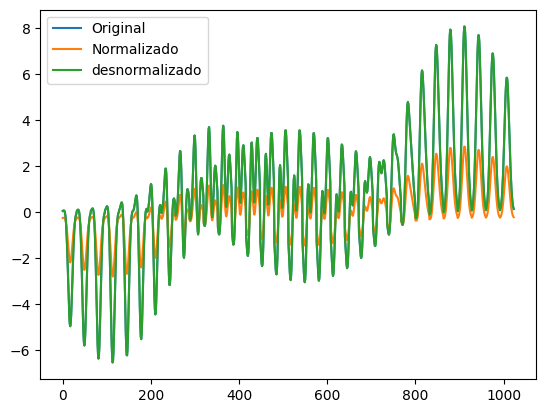

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def peaks(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return x, y, z

def create_dataframe(grid):
   x, y, z = peaks(grid)
   data = {'X': x.flatten(), 'Y': y.flatten(), 'Z': z.flatten()}
   df = pd.DataFrame(data)
   return df

def show_norm(df, label="Peaks", plot=False):
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["Z"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()


df_25 = create_dataframe(grid=5)
df_25_norm = show_norm(df_25)
test_out_scaler(df_25)

df_1000 = create_dataframe(grid=32)
df_1000_norm = show_norm(df_1000)
test_out_scaler(df_1000)



In [4]:
def split_df(df):
    _input = np.vstack([df['X'], df['Y']]).T
    _output = np.array(df['Z'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-10-28 11:16:06.528226: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-28 11:16:06.530971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-28 11:16:06.532520: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 11:16:06.548788: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-28 11:16:08.614966: W tensorflow/compiler/tf2

In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output, sup_input, sup_output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(sup_input, sup_output)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
      self._sup = (sup_input, sup_output)

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          vt_pred = self.lm_model.predict(self.vt_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))    
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_vt = r2_score(vt_denorm,  vt_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'r2_vt': r2_vt,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mse_vt': mse_vt,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product

class Tester:
  def __init__(self, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input_25, self.output_25 = split_df(df_25_norm)
    self.input_1000, self.output_1000 = split_df(df_1000_norm)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input_25, self.output_25, self.input_1000, self.output_1000)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando com 25 dados


In [ ]:
tester = Tester(run_times=25, dataset_run_times=10)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[15], [16], [17], [18], [19], [20], [21], [22], [23], [24]],
            regularizers=[0.2, 0.05],
            learning_rate=[0.01, 0.1])

Testando combinacao1: Hidden Size=[15], regularizer=0.2, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_20,0.936606,0.766494,0.924289,-8.358708,0.918344,0.423913,1.561457,1.081418,0.160901,0.621160,0.946695,0.651086,1.041120,0.678804,123.716452,198.067878
model_1_8_19,0.936238,0.766488,0.924711,-7.943480,0.919210,0.426378,1.561497,1.075383,0.153763,0.614573,0.943578,0.652976,1.041359,0.680775,123.704860,198.056285
model_1_8_21,0.936957,0.766488,0.923860,-8.778566,0.917467,0.421566,1.561498,1.087544,0.168120,0.627832,0.949353,0.649281,1.040893,0.676923,123.727556,198.078981
model_1_8_22,0.937291,0.766469,0.923424,-9.202558,0.916579,0.419335,1.561620,1.093764,0.175410,0.634587,0.951569,0.647561,1.040676,0.675129,123.738169,198.089594
model_1_8_18,0.935851,0.766469,0.925127,-7.533224,0.920064,0.428963,1.561621,1.069438,0.146709,0.608073,0.939991,0.654953,1.041610,0.682836,123.692767,198.044193
model_1_8_17,0.935446,0.766437,0.925537,-7.128441,0.920906,0.431673,1.561834,1.063581,0.139750,0.601666,0.935926,0.657018,1.041873,0.684989,123.680175,198.031600
model_1_8_16,0.935022,0.766392,0.925941,-6.729488,0.921736,0.434509,1.562136,1.057815,0.132891,0.595353,0.931370,0.659173,1.042148,0.687235,123.667077,198.018502
model_1_8_15,0.934578,0.766333,0.926339,-6.336945,0.922553,0.437475,1.562532,1.052137,0.126142,0.589139,0.926303,0.661419,1.042436,0.689577,123.653471,198.004896
model_1_8_14,0.934115,0.766259,0.926730,-5.951290,0.923357,0.440574,1.563024,1.046544,0.119511,0.583028,0.920728,0.663758,1.042736,0.692015,123.639353,197.990778
model_1_8_13,0.933631,0.766171,0.927116,-5.573086,0.924146,0.443810,1.563616,1.041036,0.113009,0.577022,0.914626,0.666190,1.043050,0.694552,123.624719,197.976144


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_6,0.942976,0.767919,0.655202,0.775038,0.715956,0.381319,1.551927,0.342526,0.181847,0.262187,0.946735,0.617510,1.036988,0.643799,123.928237,198.279663
model_1_9_7,0.943569,0.767917,0.653284,0.762074,0.709248,0.377356,1.551940,0.344431,0.192327,0.268379,0.939743,0.614293,1.036604,0.640445,123.949131,198.300557
model_1_9_5,0.942334,0.767873,0.656390,0.787282,0.721957,0.385613,1.552235,0.341346,0.171950,0.256648,0.952367,0.620977,1.037405,0.647413,123.905844,198.257270
model_1_9_8,0.944115,0.767869,0.650669,0.748457,0.701878,0.373706,1.552260,0.347029,0.203334,0.275181,0.932029,0.611315,1.036250,0.637340,123.968570,198.319996
model_1_9_9,0.944616,0.767778,0.647383,0.734256,0.693892,0.370355,1.552873,0.350293,0.214813,0.282553,0.935598,0.608568,1.035925,0.634476,123.986585,198.338010
model_1_9_4,0.941640,0.767777,0.656810,0.798730,0.727196,0.390253,1.552878,0.340928,0.162696,0.251812,0.956537,0.624703,1.037855,0.651298,123.881918,198.233343
model_1_9_10,0.945074,0.767644,0.643455,0.719530,0.685330,0.367288,1.553766,0.354195,0.226717,0.290456,0.937925,0.606043,1.035627,0.631844,124.003216,198.354641
model_1_9_3,0.940891,0.767628,0.656428,0.809302,0.731618,0.395260,1.553870,0.341308,0.154150,0.247729,0.959136,0.628697,1.038341,0.655462,123.856421,198.207846
model_1_9_11,0.945492,0.767470,0.638908,0.704336,0.676230,0.364492,1.554926,0.358712,0.238999,0.298856,0.939096,0.603732,1.035356,0.629434,124.018501,198.369927
model_1_9_2,0.940085,0.767426,0.655200,0.818920,0.735170,0.400653,1.555226,0.342528,0.146375,0.244452,0.960056,0.632971,1.038864,0.659918,123.829321,198.180746


DataFrame salvo em ../results/metrics_1_9
Testando combinacao2: Hidden Size=[15], regularizer=0.2, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=========

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_2_5,0.962615,0.770666,0.787491,0.949152,0.857397,0.249995,1.533559,0.814143,0.141262,0.477703,1.584095,0.499995,1.024250,0.521280,124.772632,199.124058
model_2_2_4,0.960921,0.770617,0.802181,0.954742,0.868115,0.261318,1.533886,0.757864,0.125734,0.441799,1.592603,0.511193,1.025348,0.532956,124.684031,199.035456
model_2_2_6,0.963775,0.770370,0.773771,0.943973,0.847404,0.242238,1.535535,0.866706,0.155651,0.511178,1.574294,0.492177,1.023497,0.513130,124.835665,199.187091
model_2_2_3,0.958538,0.770090,0.817814,0.960730,0.879537,0.277259,1.537407,0.697973,0.109098,0.403536,1.598912,0.526554,1.026895,0.548971,124.565605,198.917030
model_2_2_7,0.964525,0.769833,0.761019,0.939199,0.838132,0.237224,1.539130,0.915559,0.168914,0.542236,1.563851,0.487056,1.023011,0.507791,124.877502,199.228927
model_2_2_8,0.964962,0.769130,0.749214,0.934816,0.829564,0.234300,1.543826,0.960785,0.181091,0.570938,1.553214,0.484046,1.022727,0.504652,124.902304,199.253730
model_2_2_2,0.955264,0.768911,0.834320,0.967080,0.891609,0.299148,1.545294,0.634734,0.091456,0.363095,1.601728,0.546945,1.029018,0.570229,124.413631,198.765056
model_2_2_9,0.965163,0.768323,0.738324,0.930804,0.821674,0.232953,1.549226,1.002506,0.192236,0.597371,1.542697,0.482652,1.022597,0.503200,124.913835,199.265260
model_2_2_10,0.965189,0.767454,0.728306,0.927143,0.814427,0.232780,1.555034,1.040887,0.202408,0.621648,1.532494,0.482473,1.022580,0.503013,124.915322,199.266747
model_2_2_1,0.950848,0.766848,0.851572,0.973713,0.904225,0.328679,1.559087,0.568642,0.073029,0.320836,1.599233,0.573305,1.031882,0.597712,124.225349,198.576775


DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_3_18,0.956960,0.813410,0.909075,0.605853,0.859305,0.287807,1.247731,0.795074,0.976277,0.885676,2.203123,0.536477,1.027918,0.559316,124.490927,198.842353
model_2_3_19,0.956133,0.813401,0.907293,0.596087,0.856146,0.293336,1.247791,0.810656,1.000468,0.905562,2.209225,0.541605,1.028454,0.564662,124.452874,198.804299
model_2_3_17,0.957861,0.813398,0.911076,0.616599,0.862809,0.281781,1.247812,0.777578,0.949661,0.863619,2.195693,0.530830,1.027333,0.553429,124.533252,198.884677
model_2_3_20,0.955377,0.813376,0.905705,0.587221,0.853298,0.298396,1.247953,0.824544,1.022429,0.923486,2.214217,0.546256,1.028945,0.569511,124.418670,198.770096
model_2_3_16,0.958841,0.813356,0.913324,0.628410,0.866693,0.275230,1.248087,0.757925,0.920405,0.839165,2.186636,0.524623,1.026698,0.546958,124.580299,198.931724
model_2_3_21,0.954686,0.813342,0.904289,0.579180,0.850733,0.303016,1.248184,0.836929,1.042345,0.939637,2.218310,0.550469,1.029393,0.573904,124.387938,198.739363
model_2_3_22,0.954056,0.813300,0.903024,0.571892,0.848421,0.307230,1.248462,0.847986,1.060397,0.954190,2.221656,0.554284,1.029802,0.577881,124.360316,198.711741
model_2_3_15,0.959903,0.813276,0.915850,0.641373,0.870998,0.268132,1.248626,0.735834,0.888298,0.812066,2.175624,0.517814,1.026009,0.539859,124.632553,198.983978
model_2_3_23,0.953482,0.813255,0.901896,0.565291,0.846338,0.311066,1.248768,0.857855,1.076747,0.967301,2.224391,0.557733,1.030174,0.581477,124.335498,198.686923
model_2_3_24,0.952960,0.813207,0.900887,0.559318,0.844462,0.314554,1.249088,0.866674,1.091543,0.979109,2.226619,0.560851,1.030512,0.584728,124.313200,198.664625


DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_4_2,0.970244,0.817133,0.959535,0.990425,0.967077,0.198980,1.222831,0.430569,0.028181,0.229375,2.070730,0.446072,1.019301,0.465062,125.229101,199.580526
model_2_4_1,0.965953,0.816915,0.959006,0.994587,0.967552,0.227671,1.224288,0.436195,0.015930,0.226063,2.126261,0.477149,1.022084,0.497462,124.959710,199.311135
model_2_4_3,0.973556,0.816692,0.959527,0.986435,0.966227,0.176828,1.225779,0.430657,0.039924,0.235291,2.014536,0.420509,1.017153,0.438411,125.465156,199.816582
model_2_4_4,0.976127,0.815811,0.959194,0.982877,0.965222,0.159639,1.231672,0.434197,0.050392,0.242295,1.959287,0.399549,1.015485,0.416558,125.669679,200.021104
model_2_4_0,0.960350,0.815739,0.957600,0.998232,0.967248,0.265139,1.232155,0.451157,0.005202,0.228180,2.178921,0.514916,1.025719,0.536837,124.655006,199.006431
model_2_4_5,0.978124,0.814646,0.958667,0.979803,0.964171,0.146282,1.239461,0.439803,0.059440,0.249621,1.906030,0.382468,1.014190,0.398751,125.844438,200.195863
model_2_4_6,0.979674,0.813310,0.958026,0.977177,0.963126,0.135920,1.248396,0.446622,0.067170,0.256896,1.855459,0.368673,1.013184,0.384369,125.991376,200.342802
model_2_4_7,0.980870,0.811882,0.957321,0.974935,0.962114,0.127919,1.257943,0.454132,0.073766,0.263950,1.807984,0.357658,1.012408,0.372884,126.112712,200.464137
model_2_4_8,0.981788,0.810420,0.956583,0.973015,0.961145,0.121786,1.267721,0.461985,0.079417,0.270701,1.763801,0.348978,1.011813,0.363835,126.210980,200.562406
model_2_4_9,0.982484,0.808963,0.955834,0.971361,0.960223,0.117133,1.277463,0.469953,0.084286,0.277119,1.722958,0.342247,1.011362,0.356817,126.288893,200.640318


DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 8 ++++++++++++++++++


2024-10-28 11:22:02.368583: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_5] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_5] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_5_11,0.990679,0.815268,0.981849,0.970186,0.979547,0.062331,1.235305,0.201541,0.184041,0.192791,0.254858,0.249663,1.006046,0.260291,127.550579,201.902005
model_2_5_10,0.990775,0.815266,0.981952,0.970804,0.979810,0.061688,1.235318,0.200394,0.180229,0.190312,0.266957,0.248370,1.005984,0.258944,127.571337,201.922762
model_2_5_12,0.990589,0.815266,0.981755,0.969626,0.979308,0.062930,1.235319,0.202583,0.187500,0.195041,0.243963,0.250859,1.006104,0.261539,127.531456,201.882881
model_2_5_13,0.990506,0.815261,0.981670,0.969118,0.979092,0.063485,1.235351,0.203530,0.190632,0.197081,0.234166,0.251961,1.006158,0.262688,127.513917,201.865342
model_2_5_9,0.990878,0.815259,0.982065,0.971483,0.980099,0.061000,1.235365,0.199136,0.176032,0.187584,0.280412,0.246982,1.005917,0.257496,127.593761,201.945186
model_2_5_14,0.990430,0.815254,0.981592,0.968658,0.978896,0.063997,1.235397,0.204390,0.193471,0.198931,0.225353,0.252976,1.006208,0.263746,127.497840,201.849265
model_2_5_15,0.990359,0.815246,0.981522,0.968242,0.978718,0.064468,1.235451,0.205169,0.196040,0.200605,0.217413,0.253906,1.006254,0.264715,127.483166,201.834592
model_2_5_8,0.990987,0.815245,0.982190,0.972231,0.980418,0.060269,1.235461,0.197756,0.171417,0.184586,0.295367,0.245498,1.005846,0.255949,127.617871,201.969296
model_2_5_16,0.990295,0.815237,0.981459,0.967866,0.978557,0.064901,1.235510,0.205874,0.198365,0.202120,0.210276,0.254756,1.006295,0.265602,127.469793,201.821218
model_2_5_17,0.990235,0.815228,0.981401,0.967525,0.978412,0.065297,1.235572,0.206513,0.200465,0.203489,0.203852,0.255532,1.006334,0.266411,127.457625,201.809051


DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_6_18,0.996613,0.821361,0.990883,0.904414,0.988763,0.022650,1.194559,0.106005,0.032733,0.069369,0.160984,0.150499,1.002197,0.156906,129.575200,203.926625
model_2_6_17,0.996608,0.821360,0.990855,0.906771,0.988802,0.022679,1.194564,0.106333,0.031925,0.069129,0.161326,0.150596,1.002200,0.157007,129.572613,203.924039
model_2_6_19,0.996615,0.821360,0.990906,0.902274,0.988725,0.022638,1.194570,0.105735,0.033465,0.069600,0.160670,0.150460,1.002196,0.156865,129.576231,203.927656
model_2_6_16,0.996601,0.821357,0.990821,0.909365,0.988841,0.022732,1.194588,0.106731,0.031037,0.068884,0.161695,0.150770,1.002205,0.157188,129.568002,203.919428
model_2_6_20,0.996614,0.821356,0.990926,0.900334,0.988689,0.022639,1.194591,0.105513,0.034130,0.069821,0.160381,0.150464,1.002196,0.156870,129.576126,203.927551
model_2_6_21,0.996613,0.821352,0.990941,0.898575,0.988655,0.022650,1.194620,0.105330,0.034732,0.070031,0.160118,0.150500,1.002197,0.156907,129.575172,203.926597
model_2_6_15,0.996588,0.821349,0.990779,0.912216,0.988881,0.022814,1.194640,0.107216,0.030061,0.068638,0.162100,0.151044,1.002213,0.157474,129.560746,203.912171
model_2_6_22,0.996610,0.821347,0.990954,0.896983,0.988624,0.022668,1.194653,0.105179,0.035277,0.070228,0.159883,0.150558,1.002199,0.156967,129.573634,203.925059
model_2_6_23,0.996607,0.821342,0.990965,0.895544,0.988594,0.022690,1.194690,0.105054,0.035770,0.070412,0.159666,0.150631,1.002201,0.157043,129.571699,203.923124
model_2_6_14,0.996570,0.821336,0.990729,0.915343,0.988920,0.022936,1.194727,0.107804,0.028990,0.068397,0.162539,0.151447,1.002225,0.157894,129.550084,203.901510


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_7_0,0.996932,0.821388,0.902423,0.997583,0.986163,0.020517,1.194379,0.080475,0.014614,0.047544,0.138831,0.143236,1.001990,0.149334,129.773044,204.124469
model_2_7_1,0.997036,0.821370,0.903004,0.997181,0.985878,0.019822,1.194497,0.079996,0.017048,0.048522,0.130049,0.140789,1.001923,0.146783,129.841973,204.193398
model_2_7_2,0.997111,0.821334,0.903514,0.996785,0.985592,0.019320,1.194739,0.079575,0.019438,0.049506,0.122151,0.138997,1.001874,0.144914,129.893222,204.244647
model_2_7_3,0.997163,0.821285,0.903963,0.996403,0.985309,0.018969,1.195068,0.079205,0.021748,0.050476,0.115049,0.137729,1.001840,0.143593,129.929857,204.281283
model_2_7_4,0.997198,0.821227,0.904359,0.996038,0.985035,0.018735,1.195454,0.078878,0.023958,0.051418,0.108662,0.136877,1.001817,0.142704,129.954699,204.306124
model_2_7_5,0.997220,0.821165,0.904707,0.995691,0.984772,0.018591,1.195873,0.078591,0.026054,0.052322,0.102916,0.136348,1.001803,0.142153,129.970168,204.321593
model_2_7_6,0.997231,0.821100,0.905016,0.995365,0.984522,0.018514,1.196308,0.078336,0.028026,0.053181,0.097743,0.136068,1.001796,0.141861,129.978403,204.329828
model_2_7_7,0.997235,0.821034,0.905288,0.995060,0.984286,0.018489,1.196748,0.078112,0.029871,0.053991,0.093094,0.135975,1.001793,0.141764,129.981124,204.332549
model_2_7_8,0.997233,0.820969,0.905529,0.994776,0.984065,0.018502,1.197181,0.077913,0.031589,0.054751,0.088907,0.136022,1.001795,0.141813,129.979741,204.331166
model_2_7_9,0.997227,0.820906,0.905742,0.994513,0.983859,0.018542,1.197603,0.077738,0.033182,0.055460,0.085147,0.136170,1.001799,0.141967,129.975402,204.326827


DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 9 ++++++++++++++++

2024-10-28 11:23:27.272969: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_8] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_8_0,0.997597,0.820366,0.999916,0.999517,0.999800,0.016072,1.201216,0.000387,0.001017,0.000702,0.056163,0.126774,1.001559,0.132171,130.261403,204.612829
model_2_8_1,0.998001,0.820354,0.999832,0.998884,0.999556,0.013366,1.201296,0.000772,0.002351,0.001561,0.054383,0.115613,1.001297,0.120534,130.630044,204.981469
model_2_8_2,0.998306,0.820307,0.999656,0.998133,0.999216,0.011327,1.201607,0.001581,0.003934,0.002757,0.053158,0.106428,1.001099,0.110958,130.961162,205.312588
model_2_8_3,0.998532,0.820236,0.999405,0.997330,0.998813,0.009814,1.202080,0.002733,0.005624,0.004179,0.052455,0.099064,1.000952,0.103281,131.247957,205.599383
model_2_8_4,0.998697,0.820150,0.999096,0.996517,0.998368,0.008716,1.202660,0.004151,0.007337,0.005744,0.051844,0.093361,1.000845,0.097336,131.485116,205.836542
model_2_8_5,0.998812,0.820052,0.998744,0.995716,0.997899,0.007946,1.203312,0.005763,0.009023,0.007393,0.051300,0.089141,1.000771,0.092936,131.670161,206.021587
model_2_8_6,0.998889,0.819949,0.998365,0.994943,0.997420,0.007432,1.204003,0.007506,0.010653,0.009080,0.050825,0.086210,1.000721,0.089880,131.803898,206.155323
model_2_8_7,0.998936,0.819842,0.997968,0.994204,0.996940,0.007117,1.204714,0.009328,0.012209,0.010769,0.050415,0.084365,1.000690,0.087956,131.890416,206.241841
model_2_8_8,0.998960,0.819736,0.997563,0.993505,0.996467,0.006956,1.205428,0.011184,0.013682,0.012433,0.050062,0.083402,1.000675,0.086953,131.936322,206.287747
model_2_8_9,0.998967,0.819630,0.997159,0.992848,0.996007,0.006911,1.206132,0.013038,0.015066,0.014052,0.049751,0.083132,1.000670,0.086671,131.949304,206.300730


DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 9 +++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_2_9_0,0.998963,0.818935,0.997107,0.994542,0.995689,0.006932,1.210784,0.008581,0.033733,0.021157,0.081835,0.083257,1.000672,0.086801,131.943301,206.294727
model_2_9_1,0.998956,0.818920,0.996978,0.994524,0.995639,0.006980,1.210882,0.008963,0.033843,0.021403,0.082700,0.083545,1.000677,0.087101,131.929493,206.280919
model_2_9_2,0.998949,0.818906,0.996858,0.994508,0.995592,0.007028,1.210977,0.009321,0.033940,0.021631,0.083478,0.083832,1.000682,0.087401,131.915768,206.267193
model_2_9_3,0.998942,0.818892,0.996745,0.994494,0.995549,0.007075,1.211068,0.009655,0.034028,0.021842,0.084180,0.084114,1.000686,0.087695,131.902330,206.253755
model_2_9_4,0.998935,0.818879,0.996641,0.994481,0.995510,0.007121,1.211155,0.009965,0.034107,0.022036,0.084807,0.084386,1.000691,0.087979,131.889407,206.240833
model_2_9_5,0.998929,0.818867,0.996544,0.994470,0.995473,0.007165,1.211236,0.010251,0.034179,0.022215,0.085370,0.084646,1.000695,0.088250,131.877108,206.228533
model_2_9_6,0.998922,0.818856,0.996456,0.994459,0.995440,0.007207,1.211312,0.010513,0.034243,0.022378,0.085876,0.084892,1.000699,0.088506,131.865514,206.216939
model_2_9_7,0.998916,0.818845,0.996374,0.994450,0.995409,0.007246,1.211384,0.010755,0.034301,0.022528,0.086332,0.085123,1.000703,0.088747,131.854637,206.206063
model_2_9_8,0.998911,0.818835,0.996300,0.994442,0.995381,0.007283,1.211449,0.010977,0.034353,0.022665,0.086744,0.085338,1.000706,0.088971,131.844531,206.195957
model_2_9_9,0.998906,0.818826,0.996231,0.994434,0.995356,0.007317,1.211510,0.011179,0.034399,0.022789,0.087113,0.085538,1.000710,0.089180,131.835179,206.186604


DataFrame salvo em ../results/metrics_2_9
Testando combinacao3: Hidden Size=[15], regularizer=0.05, learning_rate=0.01
+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=======

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_3_8_6,0.930113,0.806311,0.821830,0.693222,0.854603,0.467337,1.295200,0.103986,0.582863,0.343425,1.009992,0.683621,1.045332,0.712724,123.521408,197.872833
model_3_8_7,0.930700,0.806302,0.816516,0.684374,0.850388,0.463406,1.295260,0.107088,0.599674,0.353381,1.006444,0.680739,1.044951,0.709720,123.538303,197.889728
model_3_8_5,0.929491,0.806290,0.826434,0.702017,0.858709,0.471496,1.295338,0.101300,0.566153,0.333726,1.013546,0.686656,1.045736,0.715888,123.503688,197.855113
model_3_8_8,0.931255,0.806264,0.810525,0.675476,0.846069,0.459695,1.295512,0.110585,0.616580,0.363582,1.002906,0.678008,1.044591,0.706872,123.554384,197.905809
model_3_8_4,0.928834,0.806238,0.830293,0.710753,0.862700,0.475890,1.295685,0.099047,0.549555,0.324301,1.017103,0.689848,1.046162,0.719216,123.485137,197.836563
model_3_8_9,0.931779,0.806199,0.803888,0.666534,0.841653,0.456197,1.295946,0.114458,0.633569,0.374014,0.999380,0.675424,1.044252,0.704178,123.569661,197.921086
model_3_8_3,0.928140,0.806154,0.833371,0.719425,0.866568,0.480528,1.296248,0.097251,0.533079,0.315165,1.020664,0.693201,1.046612,0.722712,123.465741,197.817167
model_3_8_10,0.932271,0.806108,0.796635,0.657553,0.837144,0.452905,1.296557,0.118691,0.650633,0.384662,0.995862,0.672982,1.043932,0.701632,123.584147,197.935573
model_3_8_2,0.927409,0.806036,0.835629,0.728027,0.870307,0.485416,1.297038,0.095933,0.516735,0.306334,1.024224,0.696718,1.047086,0.726379,123.445497,197.796922
model_3_8_11,0.932733,0.805992,0.788794,0.648536,0.832549,0.449811,1.297335,0.123268,0.667764,0.395516,0.992361,0.670680,1.043632,0.699232,123.597854,197.949279


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_3_9_11,0.940738,0.809396,0.880399,0.934011,0.945521,0.396284,1.274568,0.330093,0.407655,0.368874,0.900352,0.629511,1.038440,0.656311,123.851248,198.202674
model_3_9_12,0.941124,0.809389,0.877709,0.932188,0.944141,0.393707,1.274618,0.337517,0.418917,0.378217,0.892925,0.627461,1.038190,0.654173,123.864296,198.215721
model_3_9_10,0.940328,0.809375,0.883030,0.935808,0.946877,0.399027,1.274710,0.322831,0.396549,0.359690,0.907815,0.631685,1.038706,0.658578,123.837455,198.188880
model_3_9_13,0.941486,0.809355,0.874965,0.930347,0.942742,0.391285,1.274842,0.345090,0.430290,0.387690,0.885542,0.625527,1.037955,0.652157,123.876640,198.228066
model_3_9_9,0.939891,0.809322,0.885599,0.937572,0.948205,0.401948,1.275064,0.315741,0.385655,0.350698,0.915307,0.633994,1.038989,0.660984,123.822866,198.174291
model_3_9_14,0.941826,0.809298,0.872169,0.928493,0.941326,0.389007,1.275228,0.352805,0.441738,0.397272,0.878206,0.623704,1.037734,0.650256,123.888317,198.239743
model_3_9_8,0.939425,0.809234,0.888102,0.939289,0.949499,0.405063,1.275652,0.308831,0.375047,0.341939,0.922820,0.636446,1.039292,0.663541,123.807423,198.158849
model_3_9_15,0.942147,0.809218,0.869326,0.926632,0.939898,0.386867,1.275761,0.360652,0.453238,0.406945,0.870920,0.621986,1.037527,0.648465,123.899351,198.250776
model_3_9_16,0.942447,0.809117,0.866438,0.924765,0.938458,0.384857,1.276433,0.368625,0.464769,0.416697,0.863690,0.620368,1.037332,0.646779,123.909767,198.261192
model_3_9_7,0.938927,0.809107,0.890536,0.940944,0.950750,0.408394,1.276502,0.302114,0.364822,0.333468,0.930346,0.639057,1.039615,0.666263,123.791048,198.142473


DataFrame salvo em ../results/metrics_3_9
Testando combinacao4: Hidden Size=[15], regularizer=0.05, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [========

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_4_5_22,0.972271,0.651683,0.943112,0.425122,0.908371,0.185423,2.329197,0.422939,0.708227,0.565583,0.689116,0.430607,1.017986,0.448939,125.370236,199.721661
model_4_5_21,0.972748,0.650903,0.943940,0.441540,0.910508,0.182232,2.334414,0.416781,0.688000,0.552391,0.681122,0.426886,1.017677,0.445060,125.404951,199.756377
model_4_5_20,0.973247,0.650005,0.944869,0.459294,0.912839,0.178896,2.340421,0.409873,0.666127,0.538000,0.672253,0.422961,1.017353,0.440967,125.441902,199.793327
model_4_5_19,0.973763,0.648969,0.945912,0.478421,0.915376,0.175447,2.347344,0.402120,0.642564,0.522342,0.662423,0.418864,1.017019,0.436696,125.480837,199.832263
model_4_5_18,0.974289,0.647775,0.947083,0.498942,0.918129,0.171931,2.355330,0.393416,0.617283,0.505349,0.651535,0.414646,1.016678,0.432298,125.521320,199.872745
model_4_5_17,0.974815,0.646396,0.948397,0.520854,0.921107,0.168413,2.364552,0.383645,0.590288,0.486967,0.639476,0.410381,1.016336,0.427852,125.562673,199.914099
model_4_5_16,0.975328,0.644803,0.949872,0.544123,0.924317,0.164979,2.375203,0.372680,0.561622,0.467151,0.626133,0.406176,1.016003,0.423468,125.603876,199.955301
model_4_5_15,0.975812,0.642963,0.951525,0.568677,0.927764,0.161746,2.387508,0.360387,0.531373,0.445880,0.611386,0.402176,1.015690,0.419298,125.643462,199.994887
model_4_5_14,0.976243,0.640838,0.953376,0.594403,0.931445,0.158865,2.401721,0.346629,0.499679,0.423154,0.595100,0.398578,1.015410,0.415547,125.679404,200.030829
model_4_5_13,0.976591,0.638384,0.955442,0.621127,0.935357,0.156534,2.418125,0.331268,0.466757,0.399012,0.577127,0.395644,1.015184,0.412488,125.708960,200.060385


DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 9 ++++++++++++++++

2024-10-28 11:30:05.009971: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_6] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_6] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] |

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_4_6_0,0.971599,0.651699,0.944225,0.788851,0.862480,0.189919,2.329092,0.202234,0.853631,0.527933,0.699573,0.435797,1.018422,0.454350,125.322313,199.673739
model_4_6_1,0.970805,0.651543,0.936745,0.781162,0.854899,0.195225,2.330133,0.229356,0.884719,0.557037,0.712618,0.441842,1.018937,0.460653,125.267208,199.618634
model_4_6_2,0.969965,0.651281,0.929733,0.773750,0.847685,0.200844,2.331889,0.254781,0.914684,0.584732,0.726305,0.448156,1.019482,0.467235,125.210456,199.561881
model_4_6_3,0.969124,0.650954,0.923346,0.766727,0.840970,0.206468,2.334074,0.277941,0.943074,0.610507,0.740088,0.454388,1.020028,0.473732,125.155219,199.506644
model_4_6_4,0.968310,0.650592,0.917636,0.760151,0.834812,0.211911,2.336495,0.298642,0.969660,0.634151,0.753643,0.460338,1.020556,0.479936,125.103174,199.454599
model_4_6_5,0.967539,0.650213,0.912595,0.754047,0.829216,0.217068,2.339025,0.316922,0.994340,0.655631,0.766695,0.465906,1.021056,0.485741,125.055086,199.406511
model_4_6_6,0.966818,0.649832,0.908178,0.748413,0.824164,0.221887,2.341576,0.332937,1.017115,0.675026,0.779108,0.471048,1.021523,0.491102,125.011178,199.362603
model_4_6_7,0.966151,0.649456,0.904326,0.743239,0.819621,0.226345,2.344089,0.346903,1.038035,0.692469,0.790786,0.475758,1.021956,0.496012,124.971387,199.322812
model_4_6_8,0.965539,0.649092,0.900977,0.738503,0.815545,0.230444,2.346524,0.359047,1.057179,0.708113,0.801686,0.480046,1.022353,0.500482,124.935497,199.286923
model_4_6_9,0.964978,0.648743,0.898066,0.734181,0.811895,0.234194,2.348856,0.369601,1.074654,0.722128,0.811784,0.483936,1.022717,0.504538,124.903210,199.254636


DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_4_7_0,0.964736,0.639839,0.950510,0.806562,0.865288,0.235808,2.408398,0.069655,0.445783,0.257719,0.998834,0.485601,1.022874,0.506274,124.889476,199.240901
model_4_7_1,0.967338,0.633640,0.924053,0.791251,0.846334,0.218413,2.449848,0.106892,0.481067,0.293979,1.103083,0.467347,1.021186,0.487243,125.042731,199.394156
model_4_7_2,0.968923,0.627313,0.895470,0.773721,0.825261,0.207810,2.492157,0.147121,0.521467,0.334294,1.199484,0.455861,1.020158,0.475268,125.142266,199.493692
model_4_7_3,0.969756,0.621030,0.865893,0.755189,0.803220,0.202242,2.534172,0.188750,0.564173,0.376461,1.286837,0.449713,1.019618,0.468858,125.196584,199.548009
model_4_7_4,0.970037,0.614914,0.836128,0.736534,0.781036,0.200361,2.575074,0.230642,0.607164,0.418903,1.365054,0.447617,1.019435,0.466673,125.215270,199.566695
model_4_7_5,0.969921,0.609047,0.806750,0.718344,0.759273,0.201141,2.614305,0.271991,0.649084,0.460538,1.434236,0.448488,1.019511,0.467581,125.207497,199.558922
model_4_7_6,0.969522,0.603483,0.778162,0.700982,0.738300,0.203806,2.651509,0.312227,0.689096,0.500661,1.495081,0.451449,1.019770,0.470668,125.181169,199.532595
model_4_7_7,0.968929,0.598254,0.750644,0.684653,0.718343,0.207772,2.686477,0.350957,0.726725,0.538841,1.548447,0.455820,1.020154,0.475225,125.142630,199.494056
model_4_7_8,0.968208,0.593374,0.724391,0.669454,0.699531,0.212596,2.719110,0.387908,0.761752,0.574830,1.595196,0.461081,1.020622,0.480710,125.096727,199.448152
model_4_7_9,0.967408,0.588846,0.699527,0.655414,0.681929,0.217945,2.749392,0.422902,0.794109,0.608505,1.636139,0.466846,1.021141,0.486720,125.047027,199.398453


DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 9 ++++++++++++++++

2024-10-28 11:30:53.315113: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_8] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_8] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/ste

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_4_8_4,0.957665,0.564214,0.867104,0.976346,0.903599,0.283095,2.914106,1.267328,0.061969,0.664649,1.593942,0.532067,1.027461,0.554718,124.523942,198.875367
model_4_8_3,0.959385,0.564156,0.883807,0.982475,0.916315,0.271594,2.914490,1.108037,0.045911,0.576974,1.643447,0.521147,1.026345,0.543333,124.606891,198.958317
model_4_8_5,0.955598,0.563759,0.850947,0.970218,0.891261,0.296917,2.917147,1.421399,0.078023,0.749711,1.549014,0.544901,1.028801,0.568098,124.428606,198.780031
model_4_8_2,0.960558,0.563366,0.900734,0.988382,0.929143,0.263749,2.919777,0.946621,0.030436,0.488529,1.697855,0.513565,1.025584,0.535428,124.665518,199.016944
model_4_8_6,0.953330,0.562955,0.835543,0.964230,0.879471,0.312085,2.922522,1.568296,0.093712,0.831004,1.508315,0.558645,1.030273,0.582428,124.328962,198.680387
model_4_8_7,0.950965,0.561922,0.821009,0.958467,0.868325,0.327896,2.929431,1.706896,0.108807,0.907852,1.471518,0.572622,1.031806,0.596999,124.230120,198.581545
model_4_8_1,0.960912,0.561543,0.917393,0.993706,0.941676,0.261382,2.931964,0.787755,0.016489,0.402122,1.757515,0.511255,1.025354,0.533021,124.683544,199.034969
model_4_8_8,0.948580,0.560747,0.807404,0.952982,0.857874,0.343844,2.937284,1.836637,0.123178,0.979907,1.438296,0.586383,1.033353,0.611346,124.135132,198.486557
model_4_8_9,0.946228,0.559496,0.794746,0.947803,0.848136,0.359572,2.945650,1.957345,0.136746,1.047046,1.408325,0.599644,1.034879,0.625172,124.045679,198.397104
model_4_8_0,0.960079,0.558291,0.933084,0.997867,0.953317,0.266952,2.953713,0.638128,0.005589,0.321859,1.822777,0.516674,1.025895,0.538670,124.641372,198.992797


DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 9 +++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_4_9_24,0.971792,0.644325,0.990385,0.126360,0.856509,0.188626,2.378399,0.034796,1.143351,0.589074,0.936703,0.434310,1.018297,0.452800,125.335983,199.687408
model_4_9_23,0.971805,0.644203,0.990443,0.126752,0.856597,0.188538,2.379219,0.034586,1.142838,0.588712,0.937529,0.434210,1.018288,0.452695,125.336910,199.688335
model_4_9_22,0.971819,0.644065,0.990508,0.127172,0.856693,0.188448,2.380138,0.034352,1.142288,0.588320,0.938443,0.434106,1.018280,0.452587,125.337865,199.689290
model_4_9_21,0.971832,0.643911,0.990579,0.127618,0.856795,0.188357,2.381167,0.034094,1.141705,0.587900,0.939457,0.434001,1.018271,0.452478,125.338832,199.690257
model_4_9_20,0.971846,0.643738,0.990658,0.128085,0.856904,0.188267,2.382323,0.033808,1.141093,0.587451,0.940585,0.433898,1.018262,0.452370,125.339785,199.691211
model_4_9_19,0.971859,0.643544,0.990745,0.128575,0.857021,0.188180,2.383621,0.033492,1.140452,0.586972,0.941835,0.433798,1.018254,0.452265,125.340708,199.692134
model_4_9_18,0.971871,0.643326,0.990842,0.129079,0.857144,0.188101,2.385080,0.033143,1.139792,0.586467,0.943228,0.433706,1.018246,0.452170,125.341553,199.692978
model_4_9_17,0.971881,0.643081,0.990948,0.129589,0.857272,0.188034,2.386722,0.032757,1.139125,0.585941,0.944774,0.433628,1.018240,0.452089,125.342269,199.693694
model_4_9_16,0.971888,0.642804,0.991066,0.130098,0.857405,0.187984,2.388572,0.032332,1.138460,0.585396,0.946486,0.433571,1.018235,0.452030,125.342794,199.694220
model_4_9_15,0.971892,0.642492,0.991195,0.130585,0.857540,0.187961,2.390660,0.031863,1.137821,0.584843,0.948392,0.433545,1.018233,0.452002,125.343038,199.694463


DataFrame salvo em ../results/metrics_4_9
Testando combinacao5: Hidden Size=[16], regularizer=0.2, learning_rate=0.01
+++++++++++ [5_0] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [========

2024-10-28 11:36:51.232117: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_3] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_3] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_3] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_3] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_3] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_3] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_3] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_3] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/ste

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_6_3_5,0.951996,0.678502,0.773465,0.853533,0.848437,0.321000,2.149860,0.542832,0.779518,0.661175,0.684444,0.566568,1.028100,0.590688,132.272630,211.499559
model_6_3_4,0.951029,0.678326,0.796558,0.865775,0.862247,0.327468,2.151035,0.487496,0.714368,0.600932,0.735490,0.572249,1.028666,0.596610,132.232727,211.459656
model_6_3_6,0.952382,0.678222,0.751858,0.841826,0.835361,0.318420,2.151729,0.594606,0.841828,0.718217,0.638386,0.564287,1.027874,0.588310,132.288768,211.515697
model_6_3_7,0.952334,0.677608,0.731750,0.830697,0.823050,0.318745,2.155838,0.642790,0.901056,0.771923,0.596889,0.564575,1.027902,0.588611,132.286725,211.513654
model_6_3_3,0.949294,0.677545,0.821070,0.878486,0.876733,0.339074,2.156261,0.428757,0.646715,0.537736,0.792048,0.582300,1.029682,0.607090,132.163076,211.390005
model_6_3_8,0.951966,0.676755,0.713115,0.820177,0.811515,0.321200,2.161542,0.687445,0.957045,0.822245,0.559452,0.566746,1.028117,0.590873,132.271379,211.498308
model_6_3_2,0.946554,0.675970,0.846853,0.891582,0.891803,0.357397,2.166792,0.366976,0.577020,0.471998,0.854702,0.597827,1.031286,0.623278,132.057816,211.284745
model_6_3_9,0.951372,0.675739,0.695906,0.810282,0.800752,0.325176,2.168334,0.728680,1.009709,0.869195,0.525686,0.570242,1.028465,0.594519,132.246775,211.473704
model_6_3_10,0.950621,0.674620,0.680061,0.801015,0.790748,0.330197,2.175815,0.766650,1.059027,0.912839,0.495228,0.574628,1.028905,0.599091,132.216130,211.443059
model_6_3_11,0.949769,0.673445,0.665508,0.792372,0.781478,0.335894,2.183675,0.801522,1.105031,0.953277,0.467762,0.579564,1.029403,0.604237,132.181918,211.408846


DataFrame salvo em ../results/metrics_6_3
+++++++++++ [6_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_4] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_6_4_15,0.946574,0.694399,0.407860,0.748738,0.590003,0.357258,2.043553,1.528659,0.655548,1.092104,1.861075,0.597711,1.031274,0.623156,132.058594,211.285523
model_6_4_16,0.945943,0.694392,0.402429,0.740448,0.583311,0.361481,2.043605,1.542681,0.677177,1.109929,1.890880,0.601233,1.031643,0.626829,132.035089,211.262018
model_6_4_14,0.947246,0.694375,0.413865,0.757935,0.597417,0.352767,2.043717,1.513158,0.631554,1.072356,1.827535,0.593942,1.030880,0.619228,132.083893,211.310822
model_6_4_17,0.945353,0.694361,0.397518,0.732982,0.577275,0.365428,2.043812,1.555358,0.696657,1.126007,1.917399,0.604506,1.031989,0.630241,132.013374,211.240303
model_6_4_18,0.944804,0.694314,0.393081,0.726261,0.571834,0.369095,2.044127,1.566813,0.714190,1.140502,1.941014,0.607532,1.032310,0.633396,131.993403,211.220331
model_6_4_13,0.947954,0.694306,0.420494,0.768128,0.605621,0.348032,2.044177,1.496043,0.604959,1.050502,1.789730,0.589943,1.030466,0.615058,132.110919,211.337848
model_6_4_19,0.944297,0.694256,0.389072,0.720213,0.566929,0.372489,2.044513,1.577163,0.729970,1.153566,1.962078,0.610319,1.032607,0.636302,131.975093,211.202022
model_6_4_20,0.943828,0.694191,0.385453,0.714772,0.562510,0.375619,2.044944,1.586506,0.744167,1.165336,1.980872,0.612878,1.032881,0.638969,131.958358,211.185287
model_6_4_12,0.948693,0.694178,0.427806,0.779409,0.614689,0.343093,2.045035,1.477169,0.575527,1.026348,1.747074,0.585741,1.030034,0.610677,132.139509,211.366437
model_6_4_21,0.943398,0.694123,0.382187,0.709876,0.558530,0.378496,2.045399,1.594938,0.756939,1.175938,1.997663,0.615221,1.033133,0.641412,131.943097,211.170026


DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_5] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_6_5_1,0.960177,0.698028,0.938762,0.913097,0.956515,0.266295,2.019291,0.544033,0.111213,0.327623,1.968847,0.516037,1.023311,0.538006,132.646304,211.873232
model_6_5_0,0.956122,0.697889,0.940146,0.955450,0.960928,0.293413,2.020221,0.531738,0.057012,0.294375,1.988646,0.541676,1.025685,0.564736,132.452351,211.679280
model_6_5_2,0.962901,0.697407,0.937006,0.864684,0.951368,0.248081,2.023442,0.559636,0.173169,0.366403,1.951477,0.498078,1.021716,0.519282,132.787997,212.014926
model_6_5_3,0.964604,0.696251,0.934915,0.813598,0.945796,0.236691,2.031172,0.578209,0.238546,0.408377,1.936162,0.486509,1.020719,0.507221,132.881999,212.108928
model_6_5_4,0.965532,0.694725,0.932558,0.762029,0.940027,0.230486,2.041377,0.599154,0.304542,0.451848,1.922676,0.480090,1.020176,0.500528,132.935130,212.162058
model_6_5_5,0.965877,0.692954,0.930011,0.711358,0.934222,0.228181,2.053216,0.621777,0.369387,0.495582,1.910841,0.477683,1.019974,0.498019,132.955229,212.182158
model_6_5_6,0.965789,0.691036,0.927352,0.662452,0.928500,0.228768,2.066044,0.645403,0.431974,0.538689,1.900532,0.478297,1.020026,0.498660,132.950090,212.177018
model_6_5_7,0.965387,0.689043,0.924647,0.615836,0.922946,0.231458,2.079368,0.669435,0.491630,0.580532,1.891608,0.481100,1.020261,0.501582,132.926717,212.153645
model_6_5_8,0.964763,0.687033,0.921952,0.571812,0.917619,0.235632,2.092815,0.693376,0.547969,0.620673,1.883934,0.485419,1.020627,0.506085,132.890968,212.117897
model_6_5_9,0.963988,0.685045,0.919311,0.530528,0.912555,0.240813,2.106106,0.716836,0.600803,0.658820,1.877376,0.490727,1.021080,0.511619,132.847466,212.074394


DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 9 +++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_6_6_7,0.977981,0.715899,0.953058,0.311515,0.902885,0.147240,1.899786,0.345175,0.429543,0.387359,0.691798,0.383719,1.012889,0.400054,133.831382,213.058311
model_6_6_6,0.978919,0.715877,0.957130,0.380461,0.912030,0.140968,1.899930,0.315237,0.386527,0.350882,0.735423,0.375457,1.012340,0.391441,133.918442,213.145370
model_6_6_8,0.976994,0.715735,0.949236,0.246480,0.894275,0.153841,1.900882,0.373281,0.470117,0.421699,0.653273,0.392225,1.013467,0.408923,133.743674,212.970603
model_6_6_5,0.979758,0.715604,0.961429,0.452570,0.921632,0.135358,1.901759,0.283626,0.341539,0.312583,0.784590,0.367910,1.011849,0.383573,133.999666,213.226594
model_6_6_9,0.975994,0.715438,0.945675,0.185785,0.886245,0.160526,1.902866,0.399471,0.507985,0.453728,0.619107,0.400657,1.014052,0.417713,133.658602,212.885531
model_6_6_10,0.975008,0.715050,0.942376,0.129599,0.878811,0.167121,1.905463,0.423725,0.543039,0.483382,0.588675,0.408804,1.014629,0.426207,133.578080,212.805009
model_6_6_4,0.980431,0.714994,0.965921,0.526636,0.931565,0.130855,1.905834,0.250595,0.295329,0.272962,0.840035,0.361739,1.011455,0.377139,134.067327,213.294256
model_6_6_11,0.974053,0.714602,0.939338,0.077918,0.871968,0.173505,1.908457,0.446069,0.575283,0.510676,0.561555,0.416539,1.015188,0.434272,133.503103,212.730032
model_6_6_12,0.973142,0.714119,0.936550,0.030622,0.865699,0.179598,1.911687,0.466566,0.604790,0.535678,0.537365,0.423790,1.015722,0.441832,133.434069,212.660998
model_6_6_3,0.980851,0.713945,0.970558,0.600885,0.941647,0.128047,1.912853,0.216496,0.249006,0.232751,0.902585,0.357836,1.011209,0.373070,134.110720,213.337649


DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_6_7_4,0.975292,0.724654,0.948945,0.853874,0.868055,0.165224,1.841242,0.027834,0.527275,0.277554,0.543419,0.406478,1.014463,0.423783,133.600901,212.827829
model_6_7_3,0.976507,0.724337,0.973183,0.895479,0.906880,0.157100,1.843357,0.014620,0.377148,0.195884,0.490446,0.396359,1.013752,0.413233,133.701741,212.928670
model_6_7_5,0.973436,0.724327,0.920992,0.811362,0.827971,0.177637,1.843424,0.043072,0.680672,0.361872,0.590583,0.421469,1.015550,0.439412,133.456031,212.682960
model_6_7_6,0.971178,0.723564,0.891510,0.769252,0.788034,0.192733,1.848531,0.059145,0.832620,0.445882,0.632808,0.439013,1.016871,0.457703,133.292903,212.519831
model_6_7_2,0.976748,0.723096,0.990339,0.934247,0.942353,0.155487,1.851660,0.005267,0.237261,0.121264,0.430503,0.394318,1.013611,0.411105,133.722389,212.949318
model_6_7_7,0.968691,0.722511,0.861891,0.728404,0.749162,0.209362,1.855569,0.075292,0.980014,0.527653,0.670767,0.457561,1.018327,0.477040,133.127379,212.354308
model_6_7_8,0.966098,0.721278,0.833000,0.689366,0.711935,0.226703,1.863816,0.091043,1.120879,0.605961,0.704981,0.476134,1.019845,0.496403,132.968228,212.195157
model_6_7_1,0.975559,0.720539,0.995347,0.967391,0.971429,0.163439,1.868760,0.002537,0.117664,0.060100,0.385970,0.404276,1.014307,0.421487,133.622627,212.849555
model_6_7_9,0.963485,0.719942,0.805352,0.652464,0.676703,0.244174,1.872748,0.106116,1.254033,0.680074,0.735886,0.494139,1.021374,0.515176,132.819750,212.046679
model_6_7_10,0.960914,0.718561,0.779244,0.617874,0.643652,0.261367,1.881983,0.120349,1.378848,0.749598,0.763834,0.511240,1.022879,0.533005,132.683662,211.910591


DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Stopped at epoch:  120
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_8] | 9 ++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_6_8_0,0.988685,0.754345,0.984424,0.968375,0.980292,0.075662,1.642697,0.242103,0.230785,0.236444,0.134003,0.275067,1.006623,0.286778,135.162957,214.389886
model_6_8_1,0.988685,0.754345,0.984424,0.968375,0.980292,0.075662,1.642697,0.242103,0.230785,0.236444,0.134002,0.275068,1.006623,0.286778,135.162954,214.389883
model_6_8_2,0.988685,0.754345,0.984424,0.968375,0.980292,0.075662,1.642697,0.242104,0.230786,0.236445,0.134001,0.275068,1.006623,0.286778,135.162951,214.389879
model_6_8_3,0.988685,0.754345,0.984424,0.968375,0.980292,0.075662,1.642697,0.242104,0.230786,0.236445,0.134000,0.275068,1.006623,0.286778,135.162949,214.389878
model_6_8_4,0.988685,0.754345,0.984424,0.968375,0.980292,0.075662,1.642697,0.242104,0.230785,0.236445,0.134001,0.275068,1.006623,0.286778,135.162950,214.389878
model_6_8_5,0.988685,0.754345,0.984424,0.968375,0.980292,0.075662,1.642697,0.242105,0.230785,0.236445,0.134000,0.275068,1.006623,0.286778,135.162947,214.389875
model_6_8_6,0.988685,0.754345,0.984423,0.968375,0.980292,0.075663,1.642697,0.242105,0.230787,0.236446,0.134000,0.275068,1.006623,0.286779,135.162942,214.389871
model_6_8_8,0.988685,0.754345,0.984424,0.968375,0.980292,0.075663,1.642697,0.242105,0.230786,0.236445,0.134000,0.275068,1.006623,0.286778,135.162945,214.389874
model_6_8_7,0.988685,0.754345,0.984424,0.968375,0.980292,0.075662,1.642698,0.242105,0.230786,0.236445,0.133999,0.275068,1.006623,0.286778,135.162945,214.389874
model_6_8_9,0.988685,0.754345,0.984424,0.968375,0.980292,0.075662,1.642698,0.242104,0.230786,0.236445,0.134000,0.275068,1.006623,0.286778,135.162945,214.389874


DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_9] | 9 ++++++++++++++++

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_6_9_0,0.989137,0.754414,0.999953,0.993876,0.996772,0.072642,1.642235,0.000075,0.042598,0.021336,0.150729,0.269522,1.006359,0.280996,135.244419,214.471348
model_6_9_1,0.990514,0.754029,0.997369,0.991441,0.995179,0.063434,1.644811,0.004195,0.059532,0.031863,0.209674,0.251860,1.005553,0.262583,135.515521,214.742450
model_6_9_2,0.991354,0.753221,0.991326,0.988739,0.993028,0.057814,1.650212,0.013826,0.078327,0.046077,0.263647,0.240445,1.005061,0.250681,135.701056,214.927984
model_6_9_3,0.991795,0.752136,0.983048,0.985899,0.990535,0.054866,1.657469,0.027022,0.098086,0.062554,0.304784,0.234234,1.004803,0.244206,135.805740,215.032668
model_6_9_4,0.991942,0.750880,0.973411,0.983018,0.987857,0.053881,1.665868,0.042384,0.118126,0.080255,0.335892,0.232124,1.004717,0.242006,135.841937,215.068866
model_6_9_5,0.991877,0.749530,0.963042,0.980168,0.985107,0.054321,1.674894,0.058913,0.137946,0.098429,0.365860,0.233068,1.004755,0.242990,135.825707,215.052635
model_6_9_6,0.991660,0.748142,0.952384,0.977401,0.982365,0.055769,1.684173,0.075902,0.157194,0.116548,0.391110,0.236154,1.004882,0.246208,135.773084,215.000013
model_6_9_7,0.991340,0.746757,0.941749,0.974750,0.979688,0.057912,1.693439,0.092854,0.175633,0.134243,0.411977,0.240649,1.005069,0.250894,135.697662,214.924591
model_6_9_8,0.990951,0.745401,0.931354,0.972237,0.977112,0.060512,1.702507,0.109424,0.193114,0.151269,0.429273,0.245992,1.005297,0.256465,135.609819,214.836747
model_6_9_9,0.990520,0.744093,0.921345,0.969874,0.974661,0.063390,1.711250,0.125380,0.209551,0.167465,0.443658,0.251774,1.005549,0.262493,135.516888,214.743817


DataFrame salvo em ../results/metrics_6_9
Testando combinacao7: Hidden Size=[16], regularizer=0.05, learning_rate=0.01
+++++++++++ [7_0] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [======

,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_7_3_5,0.930847,0.769340,0.916577,0.953350,0.927782,0.462429,1.542428,0.316200,0.032155,0.174177,1.118070,0.680021,1.040480,0.708971,131.542525,210.769454
model_7_3_4,0.929990,0.768484,0.920480,0.954692,0.931041,0.468159,1.548146,0.301404,0.031230,0.166317,1.133961,0.684222,1.040982,0.713350,131.517894,210.744823
model_7_3_3,0.929101,0.767602,0.924312,0.956025,0.934242,0.474102,1.554045,0.286882,0.030311,0.158597,1.149646,0.688551,1.041502,0.717864,131.492665,210.719594
model_7_3_2,0.928180,0.766692,0.928069,0.957346,0.937383,0.480261,1.560131,0.272640,0.029401,0.151020,1.165113,0.693009,1.042041,0.722512,131.466849,210.693778
model_7_3_1,0.927226,0.765753,0.931751,0.958652,0.940462,0.486643,1.566410,0.258686,0.028501,0.143593,1.180356,0.697598,1.042600,0.727296,131.440449,210.667378
model_7_3_0,0.926237,0.764784,0.935353,0.959938,0.943477,0.493253,1.572889,0.245033,0.027614,0.136324,1.195370,0.702319,1.043178,0.732219,131.413468,210.640396


DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_4] | 9 +++++++++++++++